# Trying to make wigner coefficient sum into a function

In [39]:
#set up and fixed power spectra to work with (based on 2019-07-18 Synch maps spatial variation)


#------packages-------------------
%pylab inline

import healpy as hp

from pyshtools.utils import Wigner3j

import time

#-------constants------------------
TCMB = 2.7255  # Kelvin
hplanck = 6.626070150e-34  # MKS
kboltz = 1.380649e-23  # MKS


#-------functions------------------
#defines the ell power law that we will use for the A_s spectrum
def powerlaw(ell, alpha):
    return (ell/ 80.)**alpha

#defines a normal planck distribution 
def normed_cmb_thermo_units(nu):
    X = hplanck * nu / (kboltz * TCMB)
    eX = np.exp(X)
    return eX * X**4 / (eX - 1.)**2

#define the synchrotron SED.
#define what frequency map we want to look at. Start with 2.3 GHz
nu0 = 2.3e9 

def normed_synch(nu, beta):
    if beta is not np.array:
        beta = np.array(beta)
    return (nu/nu0)**(2.+beta[..., np.newaxis])

def scale_synch(nu, beta):
    unit = normed_synch(nu, beta) * normed_cmb_thermo_units(nu0) / normed_cmb_thermo_units(nu)
    return unit


#-------BB parameters (to start)--------
A_BB = 1.7e3
alpha_BB = -3.0
beta_BB = -3.2

#-------map paramters--------------------
nside = 128
Lmax = 384
ells = np.arange(1,Lmax+1)


#freqeuncies
#define list of frequencies going from 10 to 300 GHz, sampling 20 points
freqs = np.linspace(10,300,20)*1.e9

#define the SED scaling
sed_scaling = scale_synch(freqs, beta_BB)

#define C_ell with a power law dependence on ell
#pcls for Power law C_Ls
pcls = A_BB * powerlaw(ells, alpha_BB)
pcls[0] = 0 
pcls[1] = 0

#-----AMPLITUDE MAP----------
sbb = hp.synfast(pcls, nside, new=True, verbose=False)

#----AMPLITUDE MAP---------------------------
#these are the amplitude cls
check_pcls = hp.anafast(sbb)

#the maps including SED at different frequencies
newmaps = sbb * sed_scaling[..., np.newaxis]


#----Beta map----
beta_sigma = 1.5e-6

bcls = beta_sigma * ones_like(ells)  #makes a vector [1.5e-6, ... , 1.5e-6] with the same shape as the ells
beta_map = hp.synfast(bcls, nside, new=True, verbose=False)
#update the map so that the mean is correct
beta_map -= (np.mean(beta_map) + 3.2)


#drawn out beta cls
check_bcls = hp.anafast(beta_map)

#make series of beta maps
sed_scaling_beta = scale_synch(freqs, beta_map).T

#make ''realistic maps'' from sbb*new SED
newmaps_beta = sbb * sed_scaling_beta

Populating the interactive namespace from numpy and matplotlib


In [40]:
#---rewrite function to define the cls

def get_synch_cls(ell_max, A, alpha):
    #define synch cls up to a fixed ell
    ell = np.arange(1,ell_max+1)
    pcls = A * powerlaw(ell, alpha)
    return pcls

def get_beta_cls(ell_max, sigma):
    #define uniform c_ells up to ell max at size sigma
    ell = np.arange(1,ell_max+1)
    bcls = sigma * np.ones_like(ell)
    return bcls
    

def get_wigner_sum(ell_sum, ell_physical, cls_1, cls_2):
    #ell_sum       == upper limit on sum of ell1 ell2
    #ell_physical  == upper ell physically discernable
    #cls_1,2       == the input c_ell for the amplitude and varition (beta) map
    #order of input for cls_1,2 doesn't matter as is symmetric in both
    
    #define the relavent ells arrays
    ells = np.arange(1, ell_physical + 1) #the physical ells to be plotted
    ells_ext = np.arange(1, ell_sum + 1)  #the ells to be summed over
    
    #define an empty array to store the wigner sum in
    wignersum = np.zeros_like(ells_ext, dtype=float)
    
    #begin the sum (leave off final element so the shapes work out)
    for ell1 in ells_ext[:ell_sum-1]:
        for ell2 in ells_ext[:ell_sum-1]:
            w3j, ellmin, ellmax = Wigner3j(ell1, ell2, 0, 0, 0)
            avaliable_ells = np.arange(ellmin, ellmax+1)

            #this block forces all the w3j arrays to have the same size as the wignersum array
            #cut off trailing zeros at the end of w3j
            max_nonzero_index = ellmax - ellmin 
            w3j = w3j[:max_nonzero_index + 1]
            
            #make the w3j array the same shape as the wignersum array
            if len(w3j) < len(ells_ext):
                #if the w3j is shorter than the input ells, then pad to the end with zeros
                padding = np.zeros(len(wignersum)-len(w3j))
                w3j = np.append(w3j, padding)
            else:
                w3j=w3j

            #roll stuff into position and relabel those that roll ''around'' to 0
            w3j = np.roll(w3j, ellmin)
            w3j[:ellmin] = np.zeros_like(w3j[:ellmin])


            #cut to size of the moment that we're adding (the size of the ells matrix)
            w3j = w3j[:len(ells_ext)]
            #----------------------------------------


            #-------maps and normalisation-----------
            #define the normalisation factor in above equation
            factor = (2 * ell1 + 1)*(2 * ell2 + 1)/(4*pi)
            A = cls_1[ell1]
            B = cls_2[ell2]
            #------------------------------------------


            #define wignersum to be the array with the sum of the squares of the wigner coefficients
            wignersum += w3j**2 * factor * A * B
            
    return wignersum

#do I need to return ells?
            

In [41]:
#------generate cls of different sizes

pcls_800 = get_synch_cls(800, A_BB, alpha_BB)
bcls_800 = get_beta_cls(800, beta_sigma)

pcls_384 = get_synch_cls(384, A_BB, alpha_BB)
bcls_384 = get_beta_cls(384, beta_sigma)


In [42]:
start = time.time()
wigner_800 = get_wigner_sum(800,384, pcls_800, bcls_800)
end = time.time()
print(end-start)

43.90604901313782


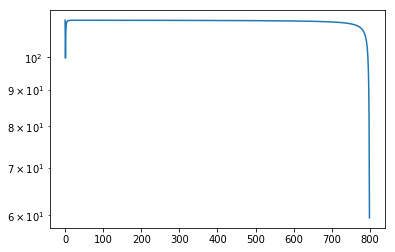

In [43]:
semilogy(wigner_800)

In [44]:
start = time.time()
wigner_384 = get_wigner_sum(384,384, pcls_384, bcls_384)
end = time.time()
print(end-start)

8.853877067565918


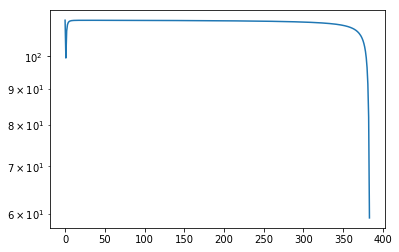

In [45]:
semilogy(wigner_384)

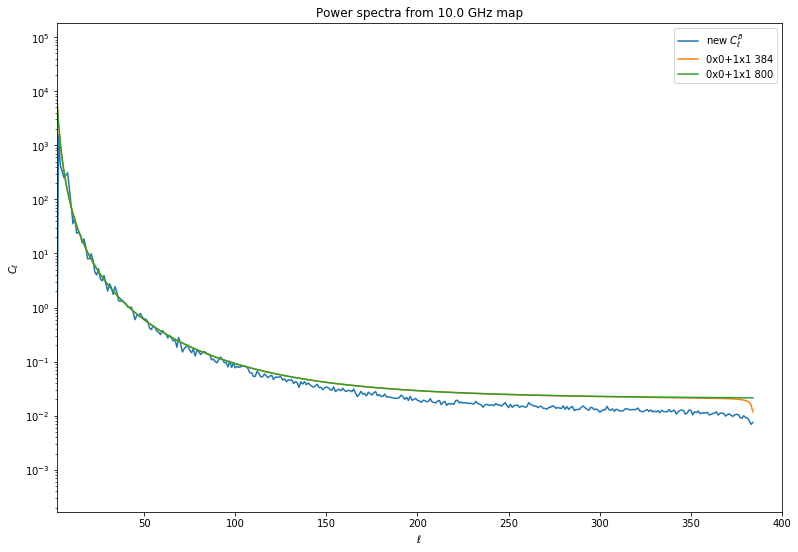

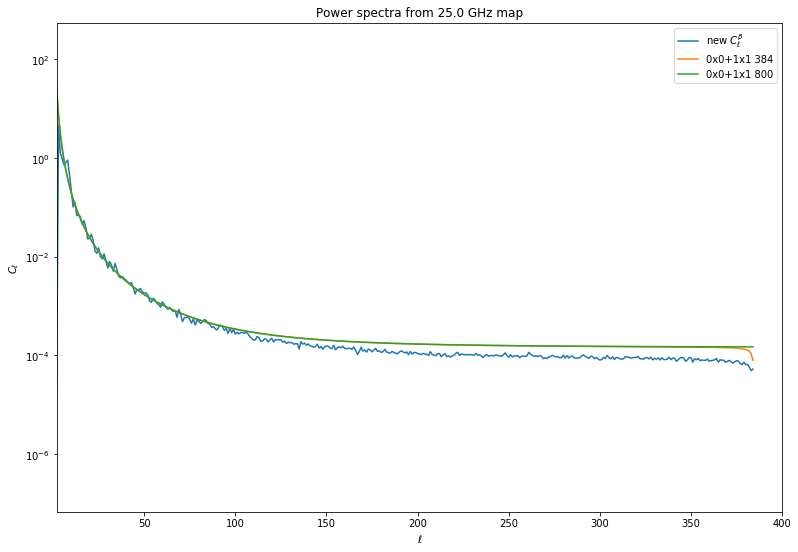

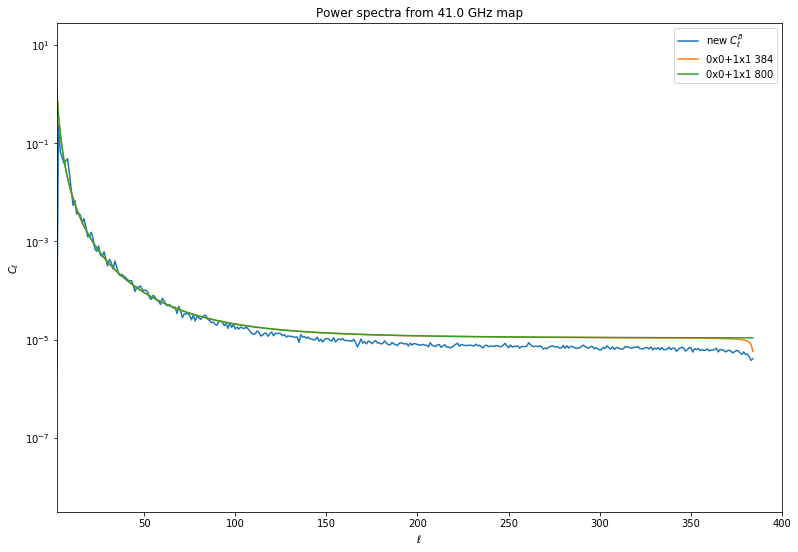

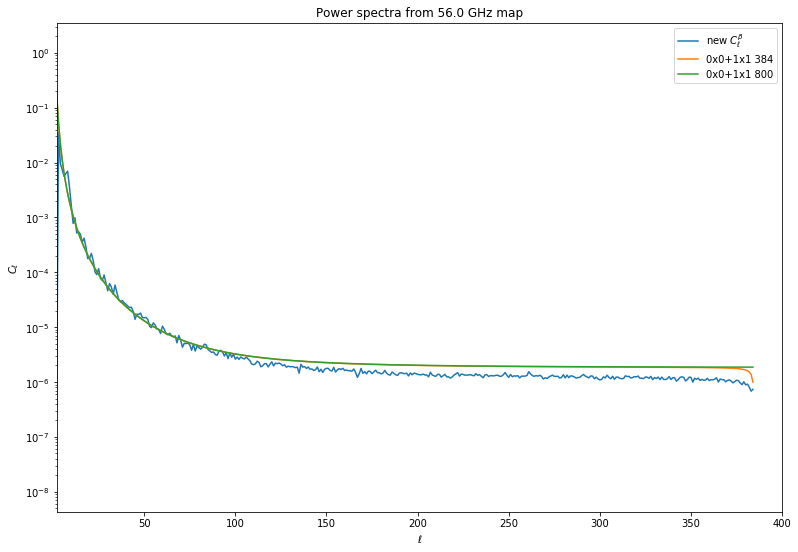

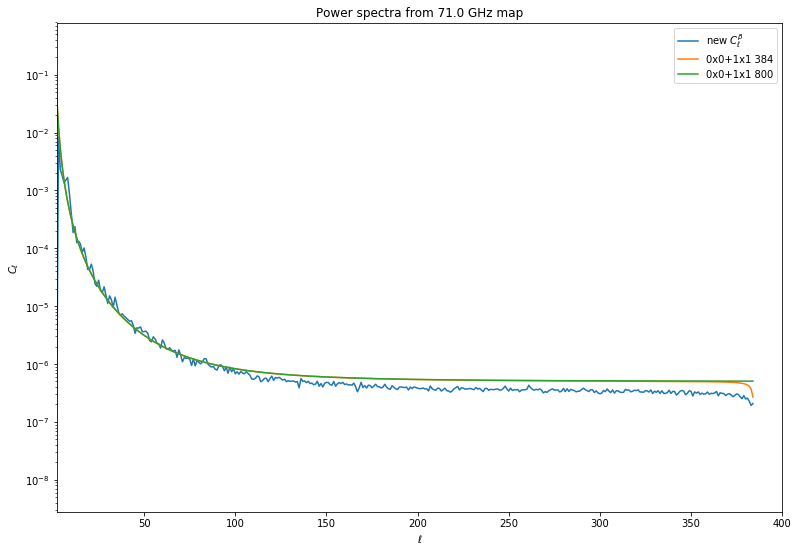

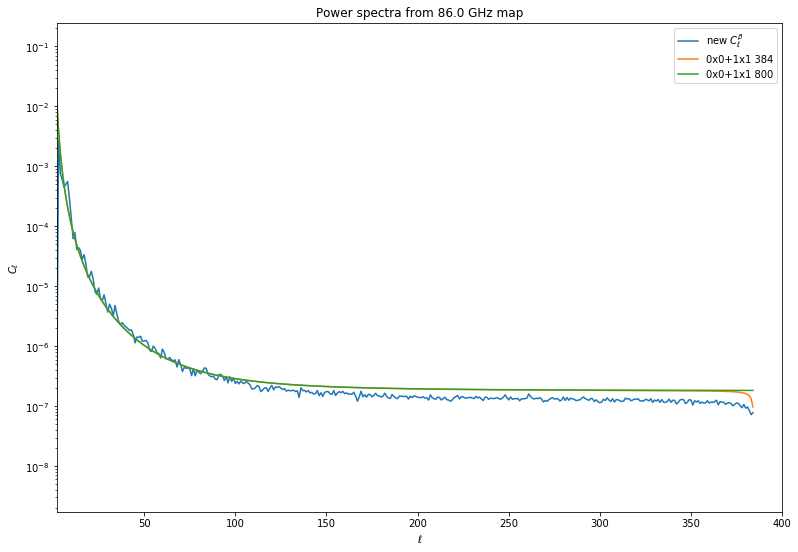

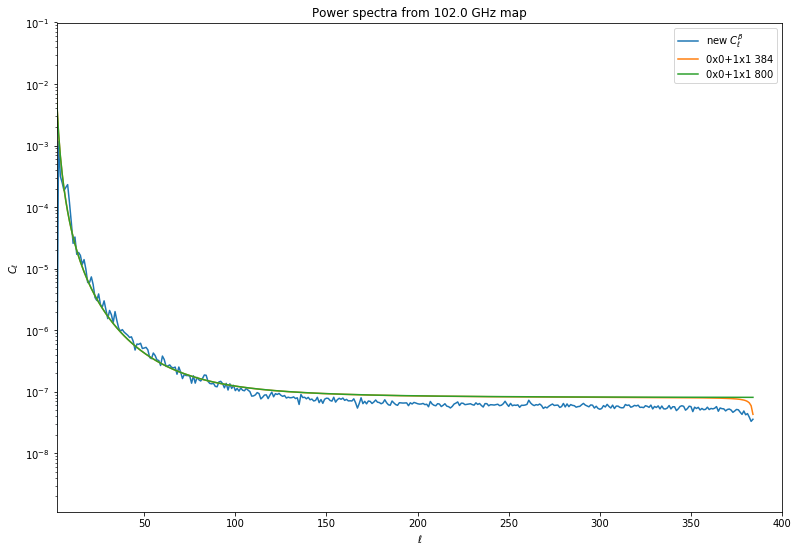

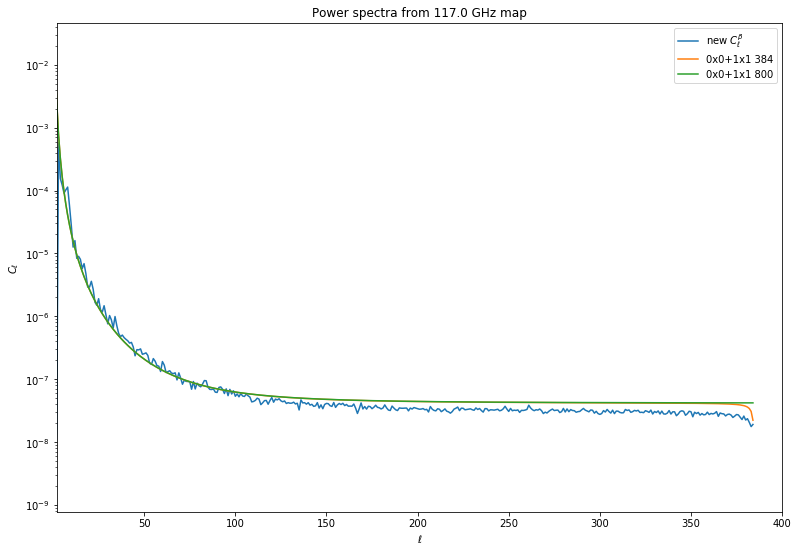

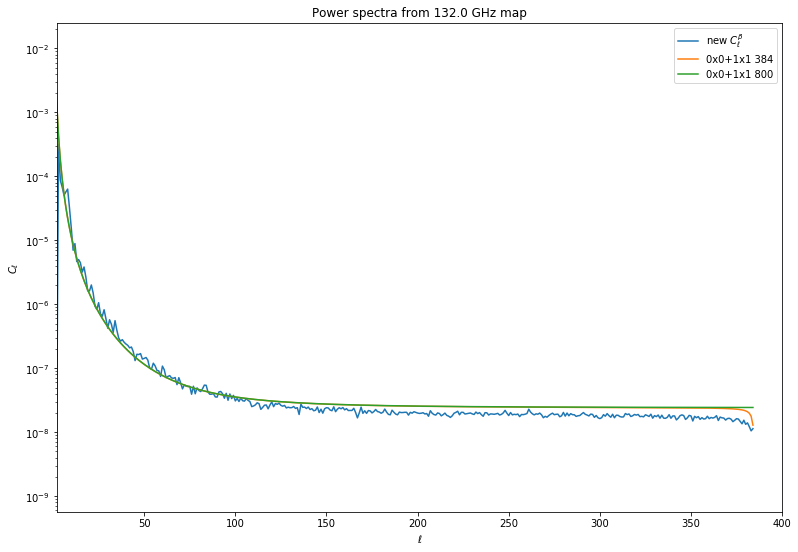

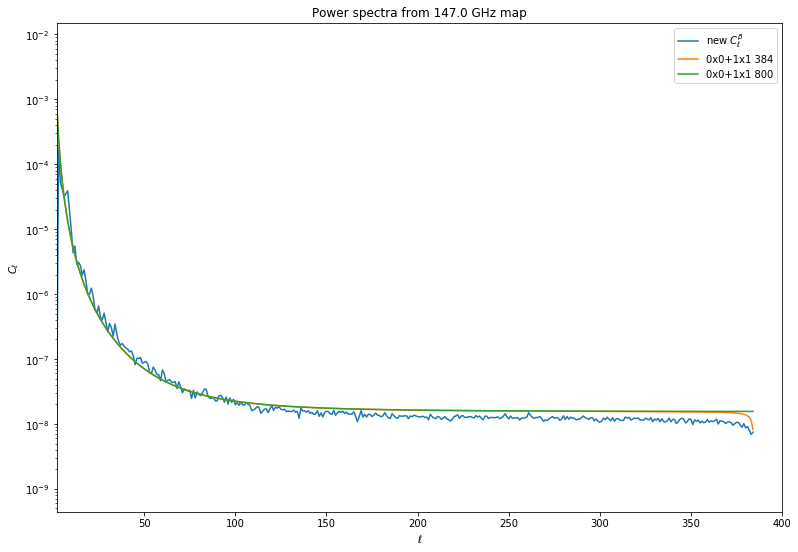

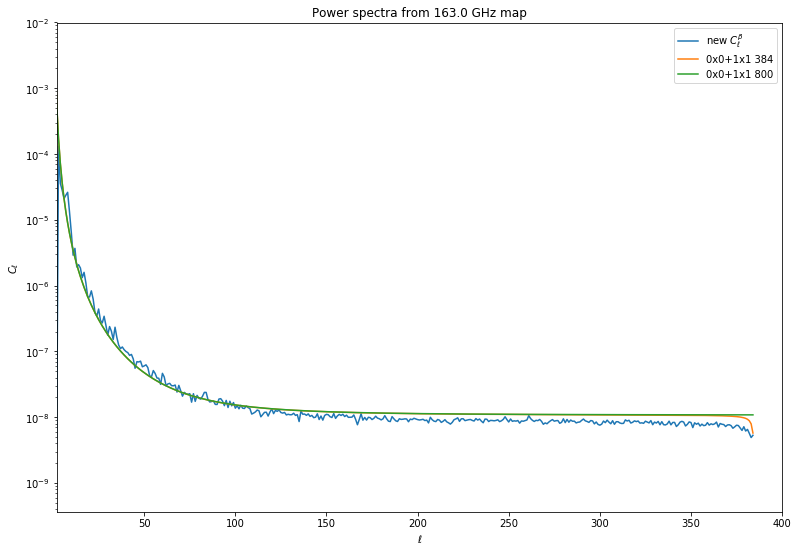

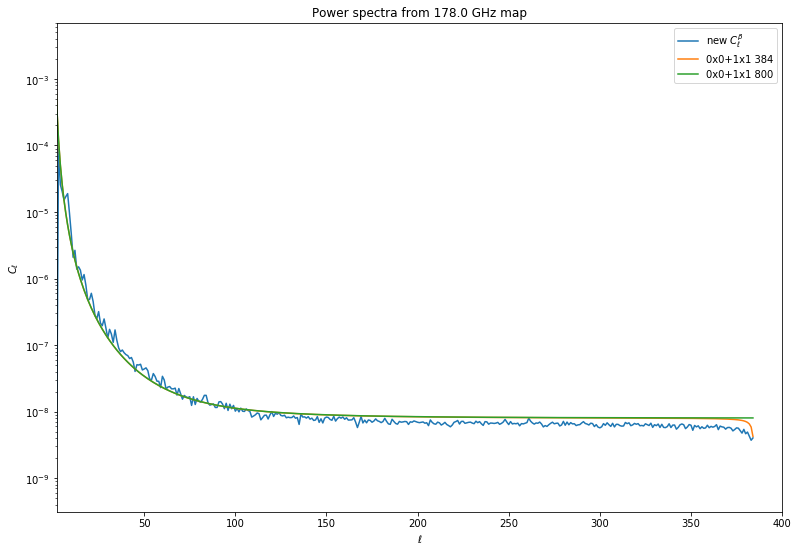

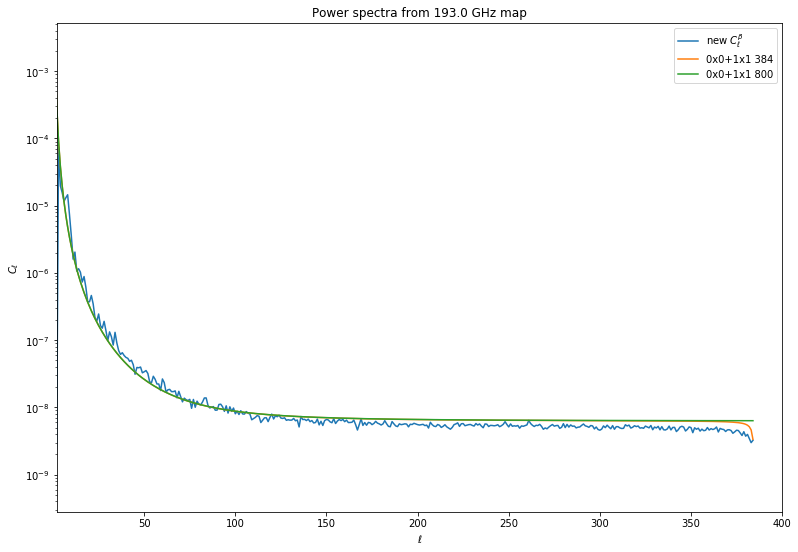

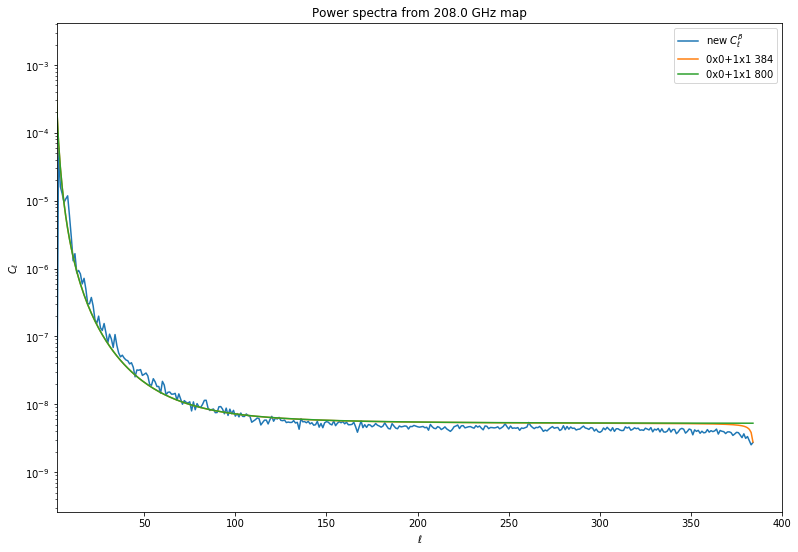

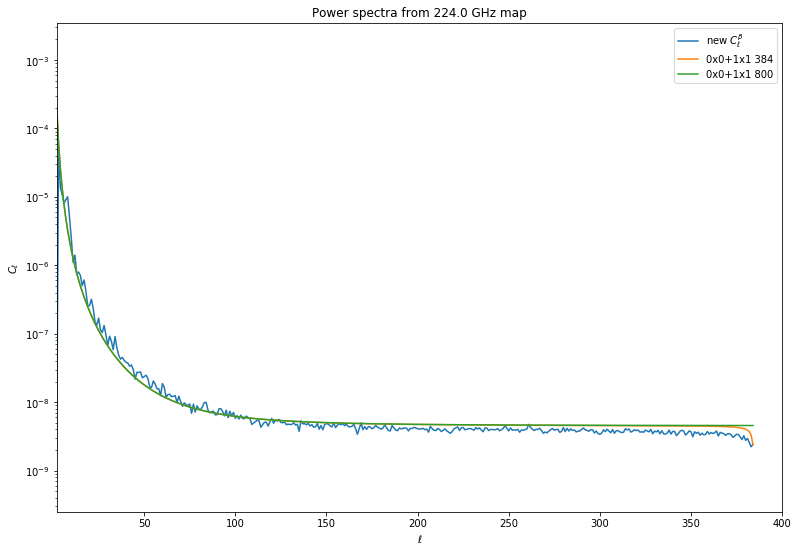

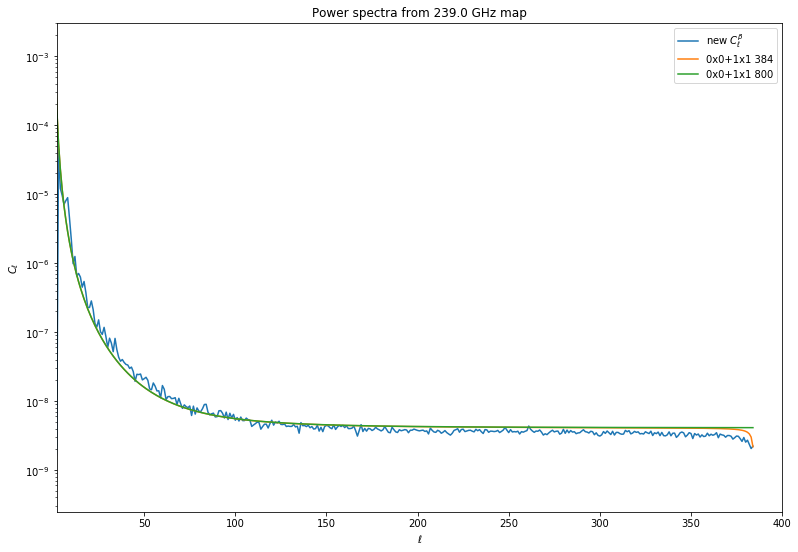

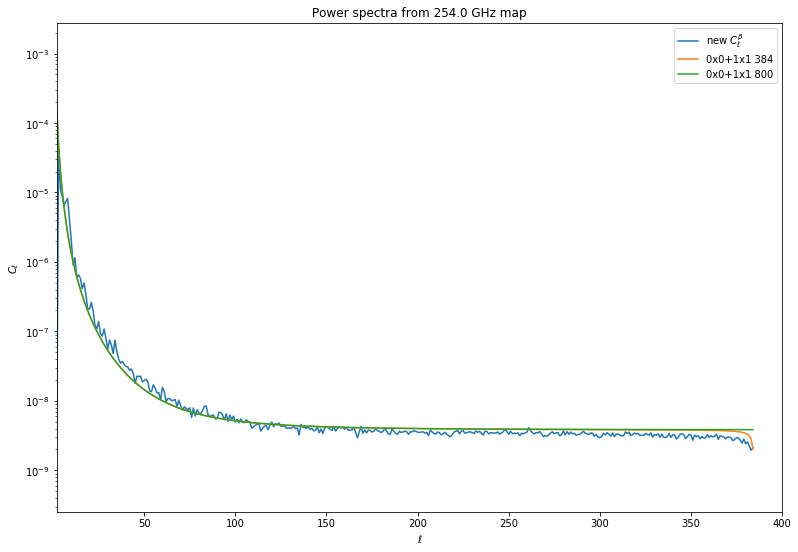

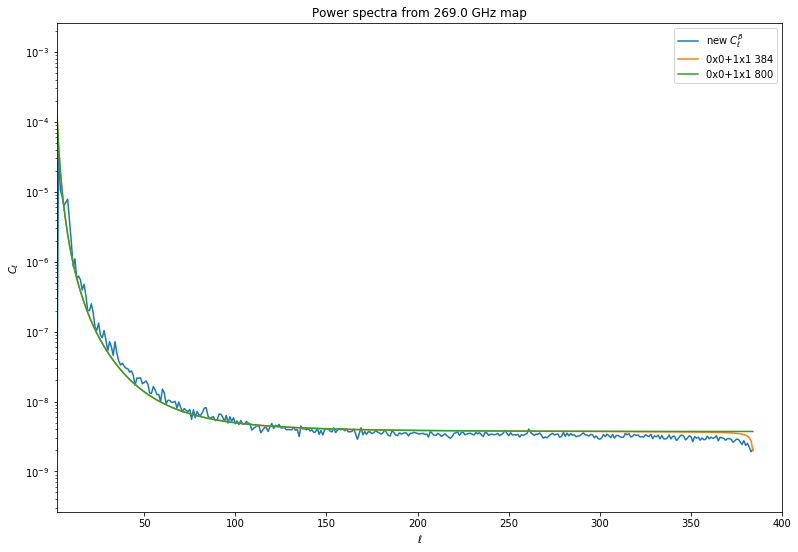

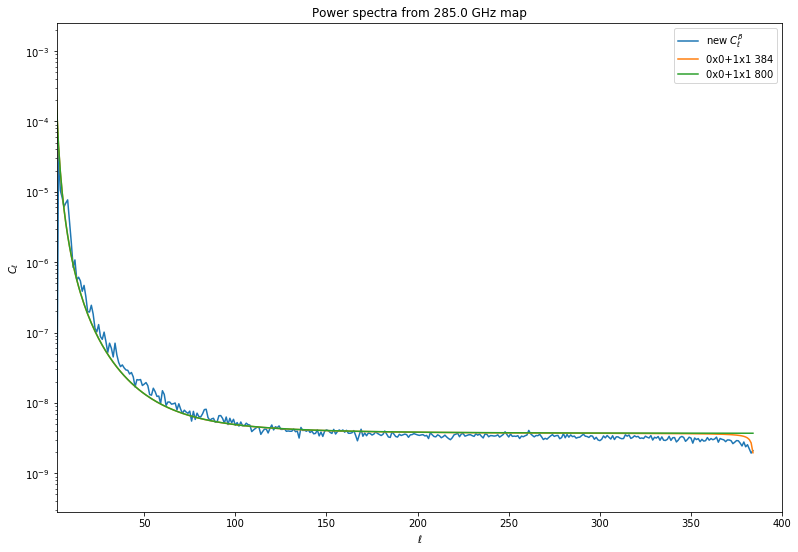

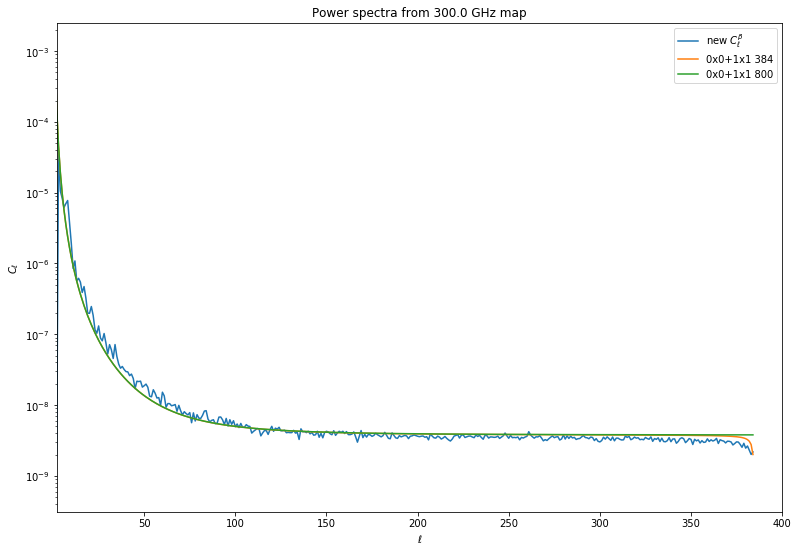

In [46]:
for k in range(20):
    moment0x0 = pcls_384*sed_scaling[k]**2        #input c_ell
    
    moment1x1_384 = log(freqs[k]/nu0)**2 * sed_scaling[k]**2 * wigner_384
    moment1x1_800 = log(freqs[k]/nu0)**2 * sed_scaling[k]**2 * wigner_800[:384]
    
    new_cls = hp.anafast(newmaps_beta[k])      #the c_ell from constant c_ell from the beta
    
    
    figure(figsize=(13,9))
    #semilogy(ells, moment0x0, label=r"(0x0) input $C_\ell $")
    semilogy(ells, new_cls, label=r"new $C_\ell^\beta$")
    #semilogy(ells, moment1x1_384, label=r"(1x1) 384")
    #semilogy(ells, moment1x1_800, label=r"(1x1) 800")
    semilogy(ells, moment1x1_384 + moment0x0, label=r"0x0+1x1 384")
    semilogy(ells, moment1x1_800 + moment0x0, label=r"0x0+1x1 800")
    title("Power spectra from " + str(round(1e-9*freqs[k])) + " GHz map" )
    xlabel(r'$\ell$')
    ylabel(r'$C_\ell$')
    xlim(2,400)
    legend();